In [57]:
import torchvision.models as models
from PIL import Image
import torch
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet44", pretrained=True).to(device)

Using cache found in C:\Users\luana/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet44-2a3cabcb.pt" to C:\Users\luana/.cache\torch\hub\checkpoints\cifar10_resnet44-2a3cabcb.pt
100.0%


3 cat 0.5481966733932495
5 dog 0.44872283935546875
6 frog 0.0015679375501349568
0 airplane 0.0007194390054792166
8 ship 0.000556546205189079


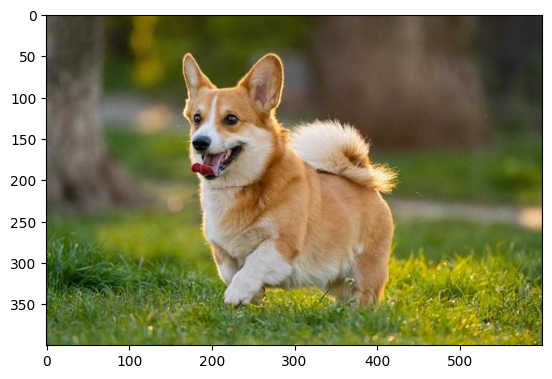

In [71]:
# test the pretrained model using a sample image

input_image = Image.open("data/dog.jpg")

preprocess = transforms.Compose([
    transforms.Resize(32),
    #transforms.CenterCrop(32),
    transforms.ToTensor(),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).to(device) # create a mini-batch as expected by the model


resnet32.eval()
with torch.no_grad():
    output = resnet32(input_batch)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Read the categories
with open("cifar10_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(top5_catid[i].item(), categories[top5_catid[i]], top5_prob[i].item())

# Show the image
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.asarray(input_image))
plt.show()

In [54]:
from lime import BinarySampler, LIMEExplainer, ExponentialKernel
from skimage.segmentation import slic

instance = np.asarray(input_image)
segments = slic(instance, n_segments=20, compactness=10)

kernel = ExponentialKernel(1e5)
sampler = BinarySampler(segments, n_jobs=8, alpha=0.7)
explainer = LIMEExplainer(similarity_kernel=kernel, sampler=sampler, model=resnet32, preprocess=preprocess)

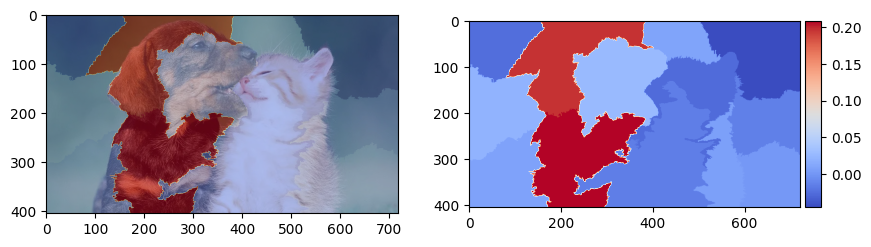

In [55]:
# explain dog
importances = explainer.explain(instance, class_to_explain=5, n_pertubations=700)

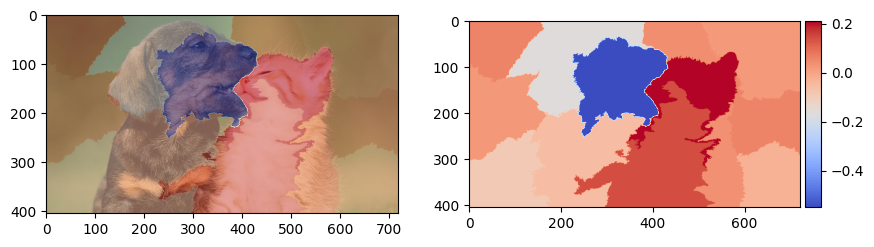

In [56]:
# explain cat
importances = explainer.explain(instance, class_to_explain=3, n_pertubations=700)